Social Network Generation
===
[RETWEET]

This is a (mostly independent) replication of Model II from Jin et al (2001). I needed it to [replicate Rolfe (2013)](https://github.com/jbn/rolfe_2012). See the [repository on github](https://github.com/jbn/jin_et_al_2001) for Python and Java code.

Overview
---

There are three processes in play in Model II.

1. **Chance Encounters**. Two nodes meet randomly. The probability of two nodes meeting in this process is unconditional. This is simply generation of two (unique) random numbers, forming a new edge. 

2. **Friends of Friends**. Model II selects a random node from the graph. Selection is proportional to $k (k -1)$ where k is the node's degree. This node represents the ego. The ego acts as a social facilitator. It randomly introduces two of its friends, or alters. An edge forms between the two selected alters. 

3. **Losing Touch**. Model II selects a node randomly from the graph. Selection is proportional to k, the node's degree. This node represents the ego. The ego randomly selects an alter and removes that edge, severing their relationship.

Model II constrains processes 1 and 2, in that a node may not exceed a degree of z*. 

Replication Results
---
At first, I tried for an independent and isolated replication. That is, I didn't peak at their source code. Unfortunately, the paper left some ambiguities. 

The authors' write:

> As before, the network is initialized by starting with no edges and running the first two steps (addition of connections)􏰄 without the third 􏰍(breaking any connections)􏰄 until all or most vertices have degree z*. Then all three steps are used for the remainder of the simulation. 

I implemented this as a barrier. That is, once some proportion of nodes had degree z*, the friendship removal function could run. Yet, what is "most"? I tried varying proportions, hoping to yield the appropriate clustering coefficient. I was unsuccessful.

Unfortunately, the [JinGir implementation I found](https://github.com/Tug/agents/blob/6eef634f80fa048e4c2fc5c62d85b384545b0e02/Repast%20J/demos/src/uchicago/src/repastdemos/jinGirNew/JinGirNewModelII.java) was incorrect. It used the wrong proportions for selection. (I don't think the authors of the paper wrote it.) But, it pointed me in the right direction with respect to the barrier. Still, my clustering coefficient remained too high. They reported a clustering coefficient, C, of 0.53. Using the same parameters, I never achieved a level that low. 

Finally, I reached out to the authors for the code. (Thank you, Michelle Girvan and M. E. J. Newman!) After perusing it, the (obvious) missing specification jumped out -- they ran the algorithm for 30,000 iterations! I was only running it for a few hundred iterations. After this modification, my clustering coefficient comported to theirs. 

I consider this to be a success. 

In [1]:
import os
JINGEN_M2 = os.path.expanduser("~/.m2/repository/com/johnbnelson/jingen/JinGen")
JINGEN_VERSION = "0.0.1"
JINGEN_JAR = os.path.join(JINGEN_M2, JINGEN_VERSION, 
                          "JinGen-{}.jar".format(JINGEN_VERSION))

In [2]:
from IPython.display import Image

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import seaborn as sns

%matplotlib inline

import jnius_config
jnius_config.set_classpath(JINGEN_JAR)
jnius_config.add_options('-Djava.awt.headless=true')
from jnius import autoclass

In [3]:
JinGen = autoclass('com.johnbnelson.jingen.JinGen')
generator = JinGen()

In [4]:
my_net = [(e.a, e.b) for e in generator.generate(250, 30000).toArray()]
my_graph = nx.Graph()
my_graph.add_edges_from(my_net)
print("Clustering Coef: {}".format(nx.cluster.average_clustering(my_graph)))

Clustering Coef: 0.475066666667


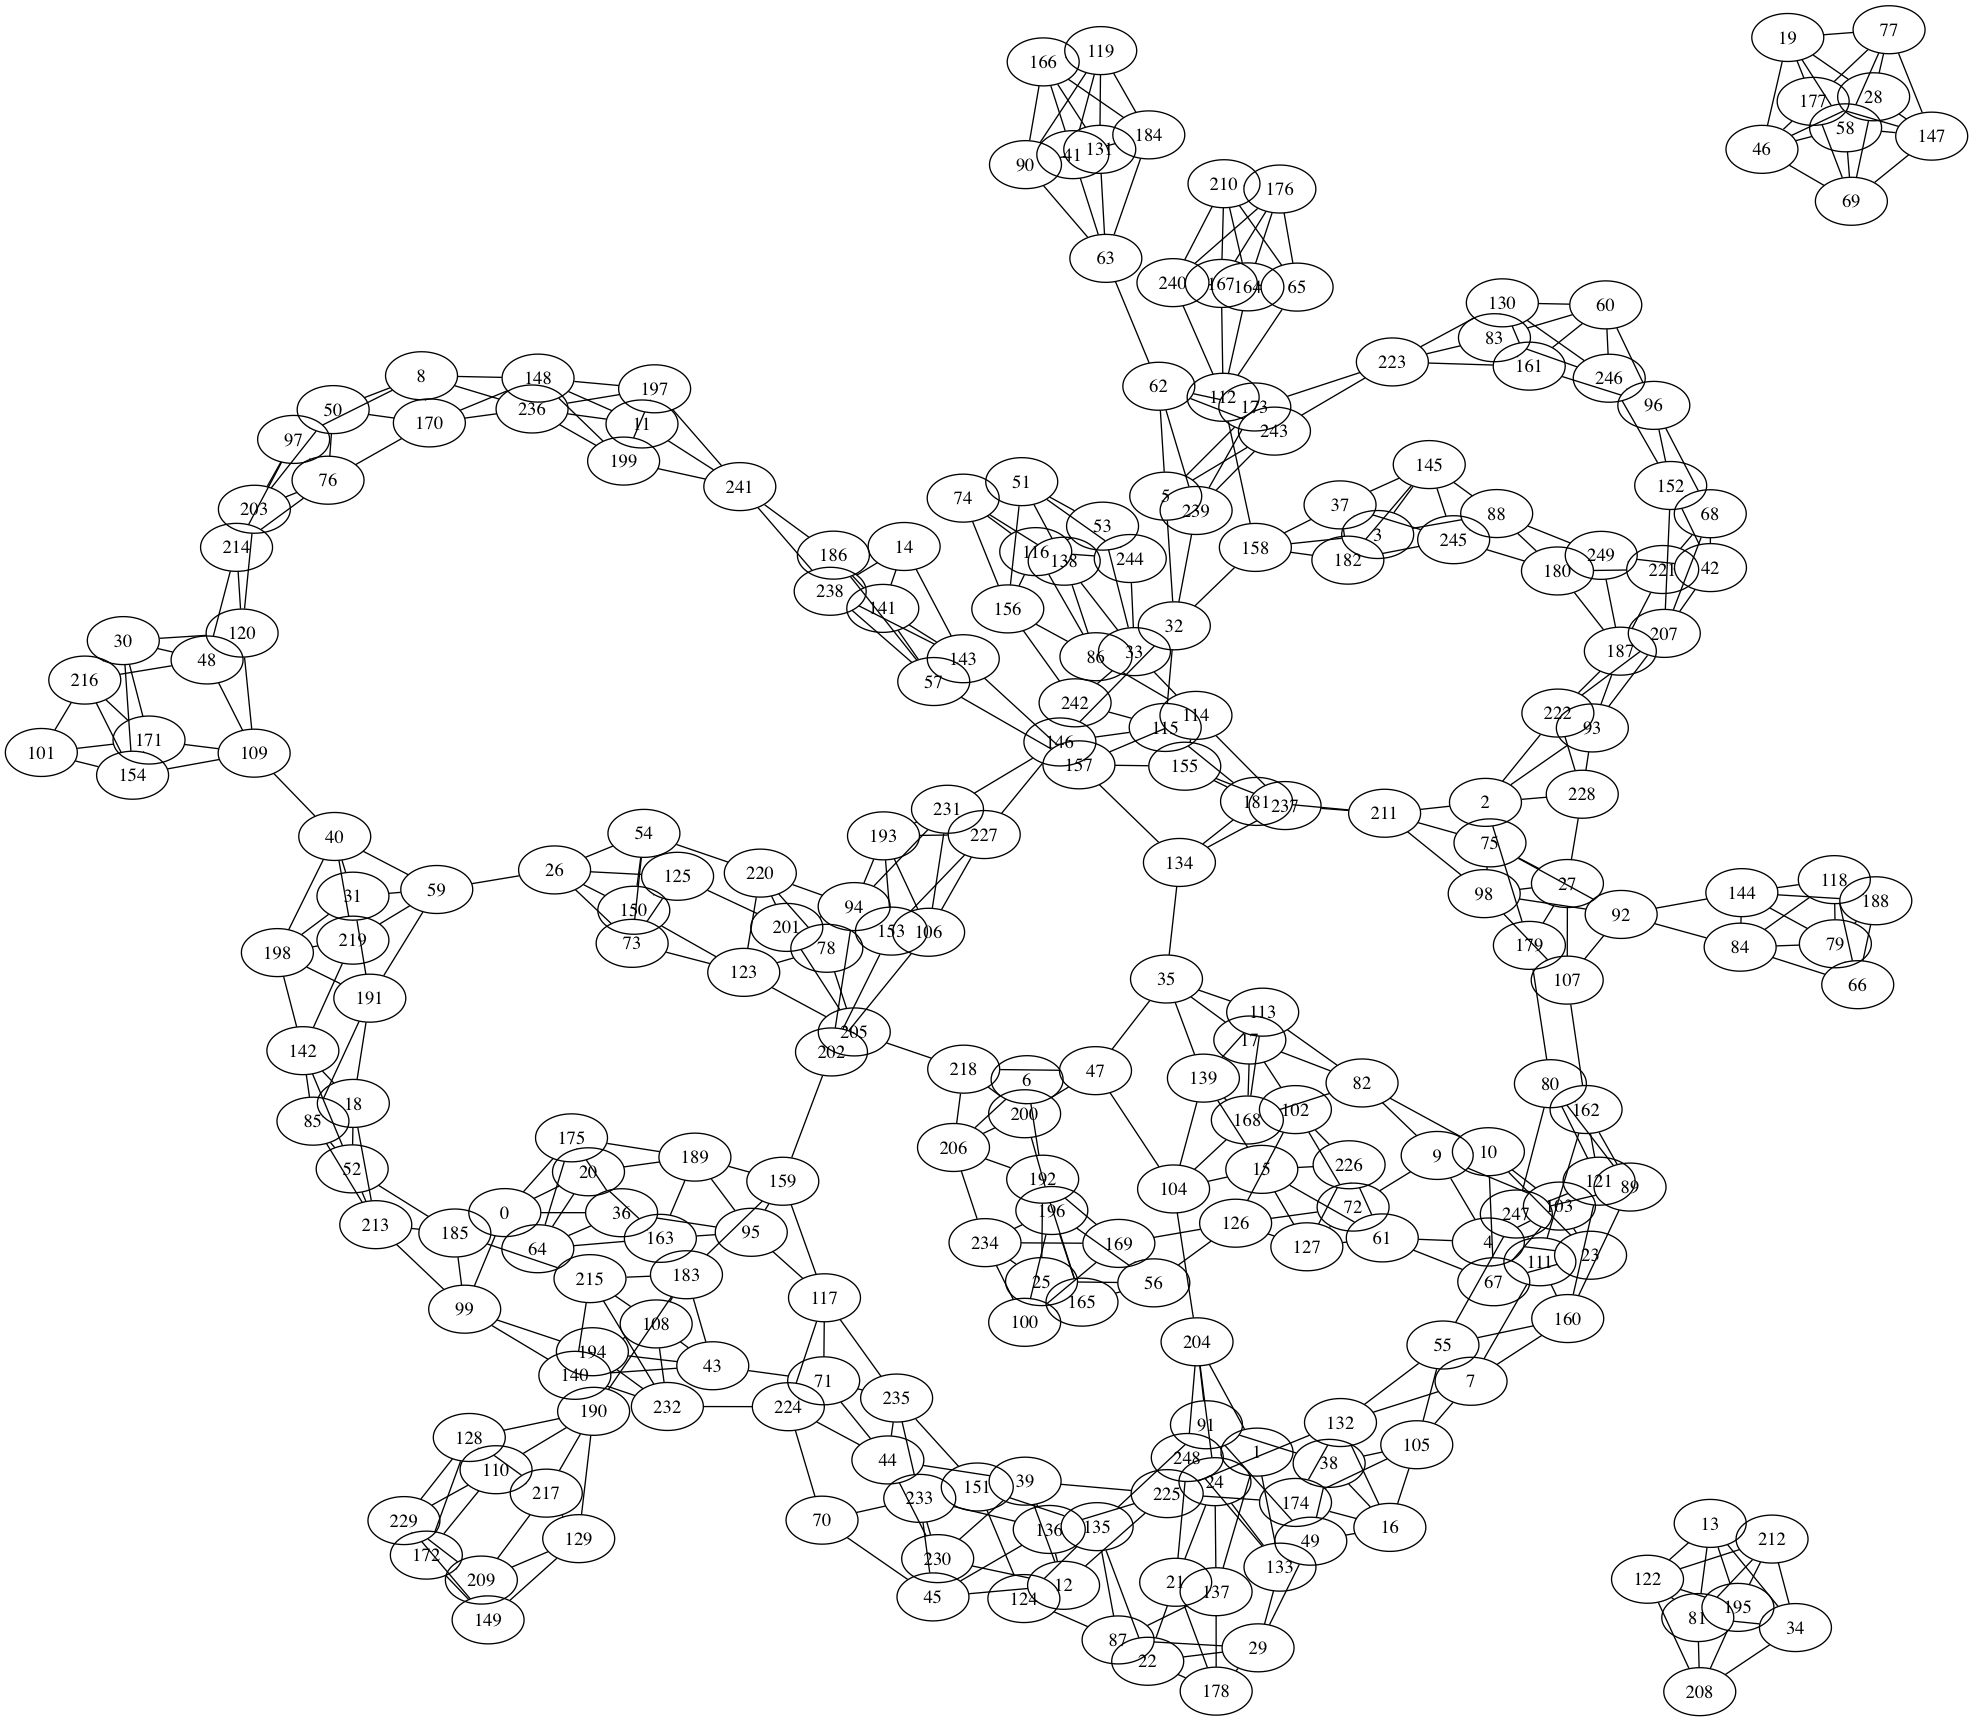

In [5]:
# Present using NEATO, since that is what the original authors used.

with open("sample_graph.dot", "w") as f:
    dot_file = "graph {\n\t"
    dot_file += "\n\t".join("{} -- {}".format(*edge) for edge in my_net)
    dot_file += "\n}"
    f.write(dot_file)

!neato -Tpng sample_graph.dot -o sample_graph.png

Image("sample_graph.png")

Note: Sampling the generator 100 times produces the following KDE. The paper reported 0.53 as the clustering coefficient. This is well-within the confidence interval of my distribution.

In [6]:
samples = []
for i in range(100):
    my_net = [(e.a, e.b) for e in generator.generate(250, 30000).toArray()]
    my_graph = nx.Graph()
    my_graph.add_edges_from(my_net)
    samples.append(nx.cluster.average_clustering(my_graph))

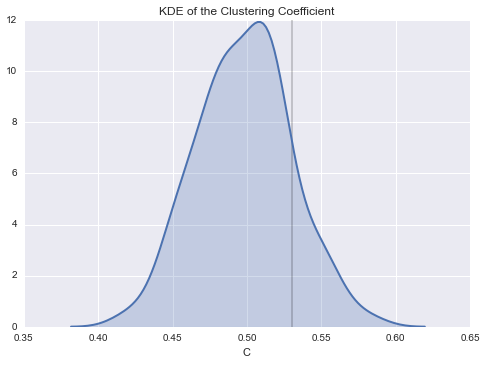

In [27]:
plt.title("KDE of the Clustering Coefficient")
plt.xlabel("C")
plt.vlines(0.53, 0, 12, alpha=0.2)
sns.kdeplot(np.array(samples), shade=True, lw=2);

Using JinGen(r)
===
Two libraries exist: one in Python and the other in Java. I prefer to play in Python, but social network generation is highly iterative. Python does not perform well. It's passable given a lower number of iterations though, so the library remains. The Java version is performant. 

I directly ported the Python code to Java. Treat the python code as the reference implementation. It is heavily commented. To avoid duplication, the Java code is not similarly commented. But, I structured the code more or less identically. And, Python's language primitives are obvious. 

Python
---

### Installation

`$ pip install jingenr`  

### Usage

```python
from jingenr import JinGen

# Create the generator. You can change the parameters specified
# by Jin et al (2001). Just be cautious. Some parameters cause
# an infinite loop. I haven't added code to guard against this
# condition yet.
generator = JinGen()  

# Generate a network. The result is a set of edges as tuples.
edges = generator.generate(250, 30000)  # 250 nodes, 30000 iters 
```

Java
---

### Installation

Add the following dependency to your `pom.xml` (or IDE).

```xml
<dependency>
  <groupId>com.johnbnelson</groupId>
  <artifactId>jingen</artifactId>
  <version>0.0.1</version>
</dependency>
```

### Usage

```java
import com.johnbnelson.jingen._

...

// Create the generator. You can change the parameters specified
// by Jin et al (2001). Just be cautious. Some parameters cause
// an infinite loop. I haven't added code to guard against this
// condition yet.
JinGen generator = JinGen()  

// Generate a network. The result is a set of edges as tuples.
Set<Edge> edges = generator.generate(250, 30000) 
```